RSAسیستم احراز هویت پیام‌ها با استفاده از کلیدهای



In [31]:
import rsa
import time
import sqlite3
import matplotlib.pyplot as plt


In [41]:


# ایجاد پایگاه داده در حافظه
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# ایجاد جدول کاربران
cursor.execute('''
CREATE TABLE users (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    username TEXT UNIQUE,
    public_key TEXT,
    private_key TEXT,
    role TEXT,
    status TEXT
)
''')

# ایجاد جدول پیام‌ها
cursor.execute('''
CREATE TABLE messages (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    sender_id INTEGER,
    message TEXT,
    signature TEXT,
    timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
    verified BOOLEAN,
    FOREIGN KEY (sender_id) REFERENCES users (id)
)
''')

print("پایگاه داده و جداول ایجاد شدند.")


پایگاه داده و جداول ایجاد شدند.


In [42]:
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives import serialization

def generate_rsa_keys():
    # تولید کلید خصوصی
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048
    )

    # تبدیل کلید خصوصی به فرمت PEM
    private_key_pem = private_key.private_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PrivateFormat.TraditionalOpenSSL,
        encryption_algorithm=serialization.NoEncryption()
    ).decode('utf-8')

    # تولید کلید عمومی
    public_key = private_key.public_key()
    public_key_pem = public_key.public_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PublicFormat.SubjectPublicKeyInfo
    ).decode('utf-8')

    return private_key_pem, public_key_pem


In [43]:
def register_user(username, role):
    private_key, public_key = generate_rsa_keys()
    cursor.execute('''
    INSERT INTO users (username, public_key, private_key, role, status)
    VALUES (?, ?, ?, ?, ?)
    ''', (username, public_key, private_key, role, 'active'))
    conn.commit()
    print(f"کاربر {username} با موفقیت ثبت شد.")

# ثبت‌نام نمونه کاربران
register_user("user1", "کاربر")
register_user("admin1", "مدیر")


کاربر user1 با موفقیت ثبت شد.
کاربر admin1 با موفقیت ثبت شد.


In [35]:
# ثبت یک کاربر نمونه
register_user("Hasti", "کاربر")

# نمایش کاربران ثبت‌شده
def list_users():
    cursor.execute("SELECT id, username, role, status FROM users")
    for user in cursor.fetchall():
        print(user)

# لیست کاربران
list_users()


کاربر 'Hasti' ثبت شد.
(1, 'Hasti', 'کاربر', 'active')


In [44]:
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding

def send_message(username, message_text):
    # بازیابی کلید خصوصی کاربر
    cursor.execute('SELECT id, private_key FROM users WHERE username = ?', (username,))
    user = cursor.fetchone()
    if not user:
        print("کاربر یافت نشد.")
        return

    user_id, private_key_pem = user
    private_key = serialization.load_pem_private_key(
        private_key_pem.encode('utf-8'),
        password=None
    )

    # امضای پیام
    signature = private_key.sign(
        message_text.encode('utf-8'),
        padding.PKCS1v15(),
        hashes.SHA256()
    )

    # ذخیره پیام
    cursor.execute('''
    INSERT INTO messages (sender_id, message, signature, verified)
    VALUES (?, ?, ?, ?)
    ''', (user_id, message_text, signature.hex(), False))
    conn.commit()
    print(f"پیام ارسال شد: {message_text}")

# ارسال نمونه پیام
send_message("user1", "این یک پیام تست است.")


پیام ارسال شد: این یک پیام تست است.


In [50]:
def verify_message(message_id):
    # بازیابی اطلاعات پیام و فرستنده
    cursor.execute('''
    SELECT m.message, m.signature, u.public_key
    FROM messages m
    JOIN users u ON m.sender_id = u.id
    WHERE m.id = ?
    ''', (message_id,))
    record = cursor.fetchone()
    if not record:
        print("پیام یافت نشد.")
        return

    message, signature_hex, public_key_pem = record
    signature = bytes.fromhex(signature_hex)
    public_key = serialization.load_pem_public_key(public_key_pem.encode('utf-8'))

    # احراز هویت امضا
    try:
        public_key.verify(
            signature,
            message.encode('utf-8'),
            padding.PKCS1v15(),
            hashes.SHA256()
        )
        cursor.execute('UPDATE messages SET verified = ? WHERE id = ?', (True, message_id))
        conn.commit()
        print("پیام با موفقیت احراز هویت شد.")
    except Exception as e:
        print("احراز هویت پیام شکست خورد:", str(e))

# احراز هویت نمونه پیام
verify_message(1)


پیام با موفقیت احراز هویت شد.


Message authentication accuracy: 100.00%


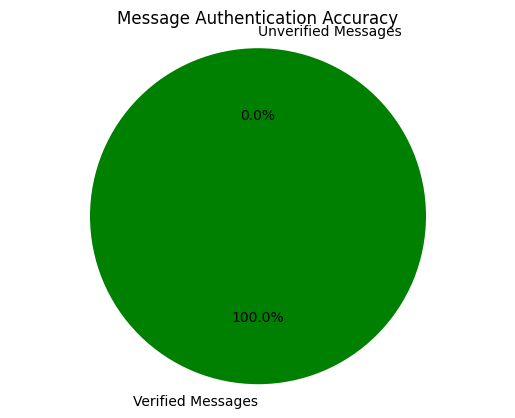

In [52]:
def plot_accuracy():
    """
    Calculate and visualize the accuracy of message authentication.
    """
    # Retrieve total number of messages
    cursor.execute("SELECT COUNT(*) FROM messages")
    total_messages = cursor.fetchone()[0]

    # Retrieve number of verified messages
    cursor.execute("SELECT COUNT(*) FROM messages WHERE verified = 1")
    verified_messages = cursor.fetchone()[0]

    # Calculate accuracy
    if total_messages > 0:
        accuracy = (verified_messages / total_messages) * 100
    else:
        accuracy = 0

    # Display accuracy
    print(f"Message authentication accuracy: {accuracy:.2f}%")

    # Plot pie chart
    labels = ["Verified Messages", "Unverified Messages"]
    values = [verified_messages, total_messages - verified_messages]

    plt.pie(
        values,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=["green", "red"],
    )
    plt.title("Message Authentication Accuracy")
    plt.axis("equal")  # Ensures the chart is circular
    plt.show()

# Call the plot_accuracy function
plot_accuracy()
